# MetroPT-3 Dataset

El **MetroPT-3 Dataset** es un conjunto de datos multivariado y temporal diseñado para tareas de mantenimiento predictivo, detección de anomalías y estimación de vida útil remanente (RUL) en compresores de unidades de producción de aire (APU) de trenes. Los datos se registraron entre febrero y agosto de 2020 a una frecuencia de 1Hz, proporcionando 15 características extraídas de sensores analógicos y digitales. Contiene información sin etiquetar, pero se acompañan reportes de fallas para evaluar modelos.

---

## Descripción de las columnas (atributos):

- **TP2 (bar):** Presión en el compresor.
- **TP3 (bar):** Presión generada en el panel neumático.
- **H1 (bar):** Presión causada por la caída al descargar el filtro separador ciclónico.
- **DV Pressure (bar):** Presión de descarga en secadores de aire (valor 0 indica operación bajo carga).
- **Reservoirs (bar):** Presión en los depósitos, debe aproximarse a TP3.
- **Motor Current (A):** Corriente de un motor trifásico:
  - `0A`: Apagado.
  - `4A`: Sin carga.
  - `7A`: Bajo carga.
  - `9A`: Encendido.
- **Oil Temperature (ºC):** Temperatura del aceite en el compresor.
- **COMP:** Señal eléctrica de la válvula de admisión de aire; indica estado apagado o sin carga.
- **DV Electric:** Señal eléctrica que controla la válvula de salida del compresor; activa bajo carga.
- **TOWERS:** Señal que identifica la torre activa para secado o drenaje de humedad:
  - **Inactiva:** Torre 1.
  - **Activa:** Torre 2.
- **MPG:** Señal para iniciar el compresor bajo carga si la presión cae por debajo de 8.2 bar.
- **LPS:** Señal que activa cuando la presión baja de 7 bar.
- **Pressure Switch:** Señal que detecta descargas en torres de secado de aire.
- **Oil Level:** Señal que detecta niveles de aceite bajos.
- **Caudal Impulse:** Pulso generado por el flujo de aire hacia los depósitos.

In [21]:
import datetime

import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
plt.style.use('ggplot')

# Lectura y descripción de datos
Leemos los datos y sacamos estadísticos básicos, así como porcentaje de nulos y alguna limpieza básica inicial.

In [22]:
# ----- Read data ----- #
csv_path = "MetroPT3(AirCompressor).csv"
data = pl.read_csv(csv_path)

# ----- Summarizing data ----- #
print(data.shape)
print(data.columns)
print(data.describe())
print(data.null_count())
for col, dtype in zip(data.columns, data.dtypes):
    print(f"Column: {col}, Type: {dtype}")
# ----- Cleaning data ----- #
# Columns that are not features
data = data.drop(pl.col(""))
print(len(data.columns))
print(data.describe())

(1516948, 17)
['', 'timestamp', 'TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Oil_temperature', 'Motor_current', 'COMP', 'DV_eletric', 'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses']
shape: (9, 18)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆           ┆ timestamp ┆ TP2       ┆ … ┆ LPS       ┆ Pressure_ ┆ Oil_level ┆ Caudal_i │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ switch    ┆ ---       ┆ mpulses  │
│ str       ┆ f64       ┆ str       ┆ f64       ┆   ┆ f64       ┆ ---       ┆ f64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆ f64       ┆           ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 1.516948e ┆ 1516948   ┆ 1.516948e ┆ … ┆ 1.516948e ┆ 1.516948e ┆ 1.516948e ┆ 1.516948 │
│           ┆ 6         ┆           ┆ 6         ┆   ┆ 6         

# Transformaciones
- Inicialmente vamos a transformar la variable de timestamp en formato de tiempo para poder filtrarla bien y trabajar comodamente con ella.

In [23]:
# Convert timestamp to Datetime (only if necessary)
if data["timestamp"].dtype == pl.Utf8:
    data = data.with_columns(
        pl.col("timestamp").str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S")
    )
print(data["timestamp"])

shape: (1_516_948,)
Series: 'timestamp' [datetime[μs]]
[
	2020-02-01 00:00:00
	2020-02-01 00:00:10
	2020-02-01 00:00:19
	2020-02-01 00:00:29
	2020-02-01 00:00:39
	…
	2020-09-01 03:59:10
	2020-09-01 03:59:20
	2020-09-01 03:59:30
	2020-09-01 03:59:40
	2020-09-01 03:59:50
]


- Vamos a estandarizar los datos para poder visualizarlos y que las escalas no afecten demasiado a estas visualizaciones.

In [24]:
scaler = StandardScaler(with_std=False)

# We should not normalize timestamp
timestamp = data["timestamp"]

# Normalize the remaining columns
data_norm_array = scaler.fit_transform(data.select(pl.exclude("timestamp")).to_numpy())
data_norm = pl.DataFrame(data_norm_array, schema=data.select(pl.exclude("timestamp")).columns)

# Add the "timestamp" column back to the normalized data
data_norm = data_norm.with_columns(timestamp)

print(data_norm)

shape: (1_516_948, 16)
┌───────────┬───────────┬──────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ TP2       ┆ TP3       ┆ H1       ┆ DV_pressu ┆ … ┆ Pressure_ ┆ Oil_level ┆ Caudal_im ┆ timestamp │
│ ---       ┆ ---       ┆ ---      ┆ re        ┆   ┆ switch    ┆ ---       ┆ pulses    ┆ ---       │
│ f64       ┆ f64       ┆ f64      ┆ ---       ┆   ┆ ---       ┆ f64       ┆ ---       ┆ datetime[ │
│           ┆           ┆          ┆ f64       ┆   ┆ f64       ┆           ┆ f64       ┆ μs]       │
╞═══════════╪═══════════╪══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ -1.379826 ┆ 0.373389  ┆ 1.771845 ┆ -0.079956 ┆ … ┆ 0.008563  ┆ 0.095844  ┆ 0.062893  ┆ 2020-02-0 │
│           ┆           ┆          ┆           ┆   ┆           ┆           ┆           ┆ 1         │
│           ┆           ┆          ┆           ┆   ┆           ┆           ┆           ┆ 00:00:00  │
│ -1.381826 ┆ 0.363389  ┆ 1.763845 ┆ -0.077956 ┆ … ┆ 0.008563  ┆ 0.0

# Visualizaciones

In [25]:
max_time = data_norm.filter(pl.col("timestamp") == data_norm["timestamp"].max()).select(
    pl.col("timestamp")
)
min_time = data_norm.filter(pl.col("timestamp") == data_norm["timestamp"].min()).select(
    pl.col("timestamp")
)

print(max_time)
print(min_time)

shape: (1, 1)
┌─────────────────────┐
│ timestamp           │
│ ---                 │
│ datetime[μs]        │
╞═════════════════════╡
│ 2020-09-01 03:59:50 │
└─────────────────────┘
shape: (1, 1)
┌─────────────────────┐
│ timestamp           │
│ ---                 │
│ datetime[μs]        │
╞═════════════════════╡
│ 2020-02-01 00:00:00 │
└─────────────────────┘


In [26]:
def plot_time_series(
    data: pl.DataFrame,
    col: str,
    start_date: datetime.datetime,
    end_date: datetime.datetime,
):
    # Filter the data
    filtered_data = data.filter(
        (pl.col("timestamp") >= start_date) & (pl.col("timestamp") <= end_date)
    )

    plt.figure(figsize=(15, 4))
    sns.lineplot(data=filtered_data, x="timestamp", y=col, label=col)
    plt.title(f"{col} Over Time")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

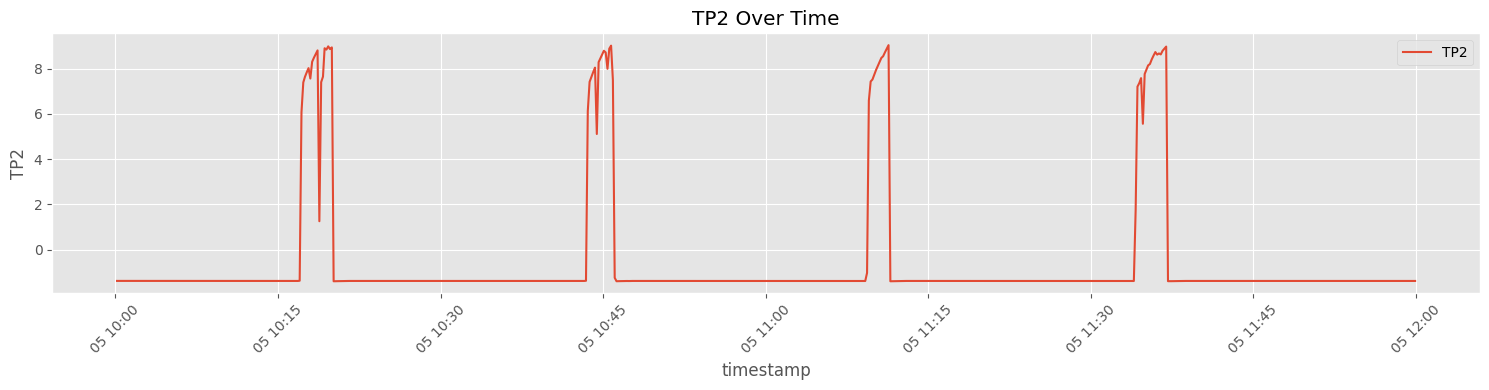

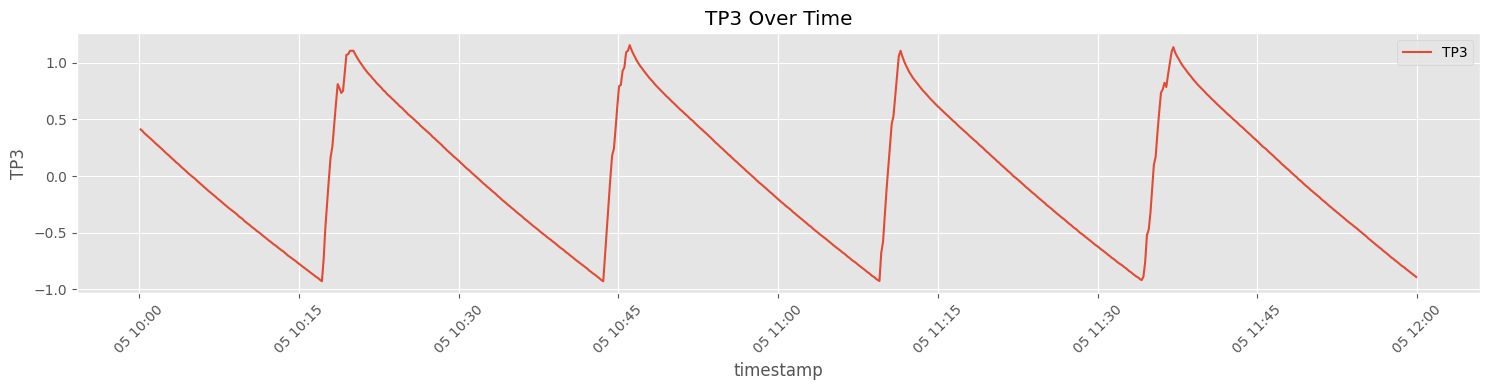

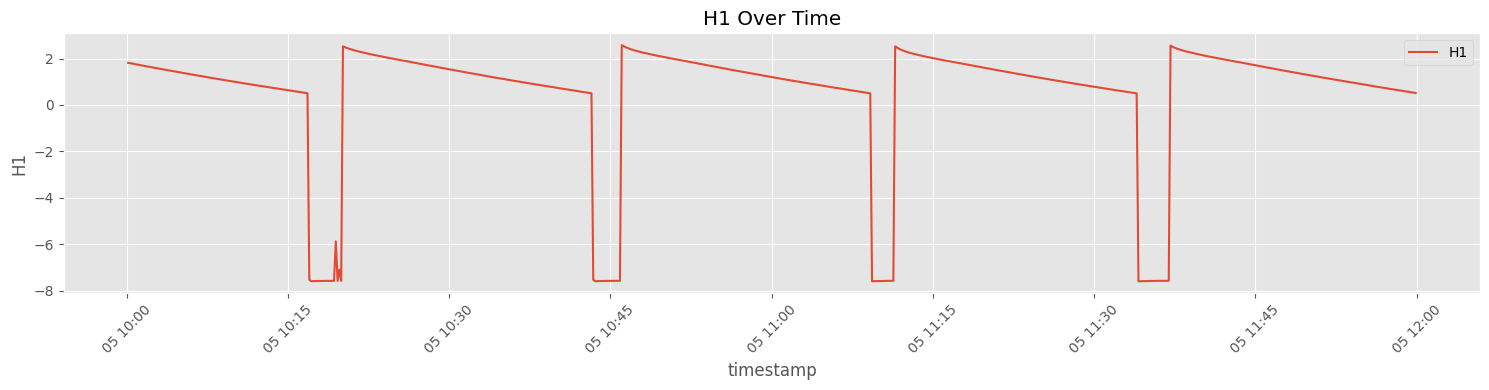

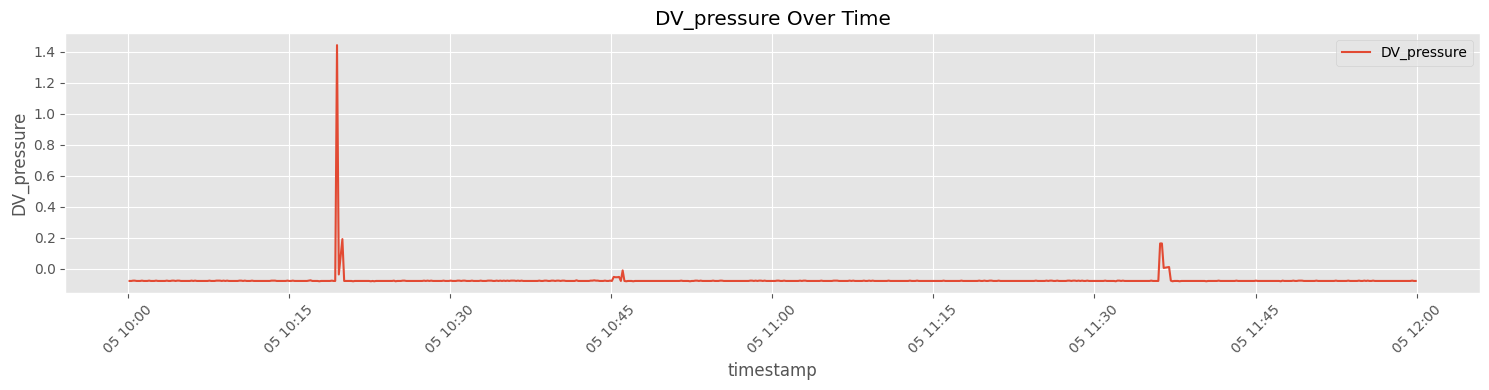

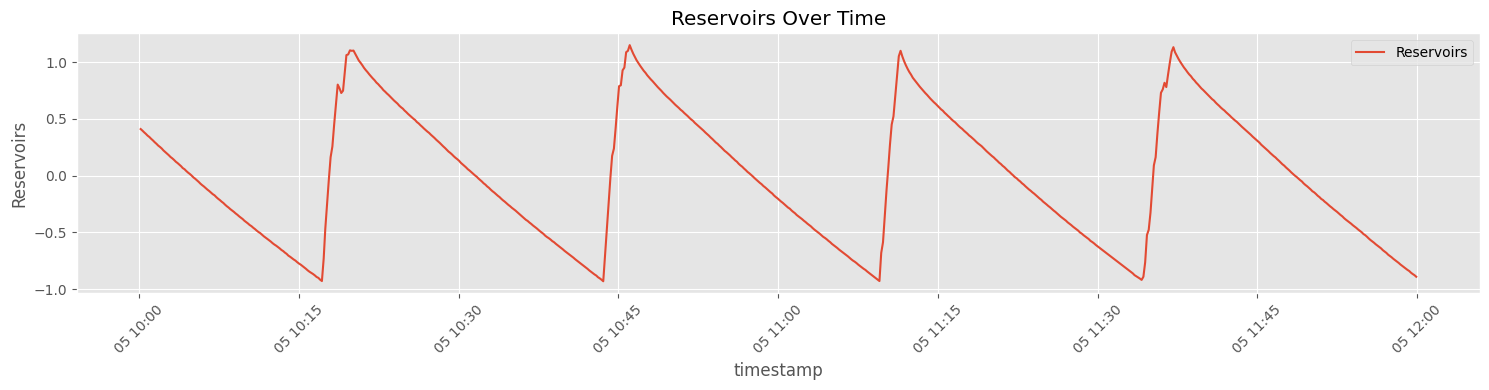

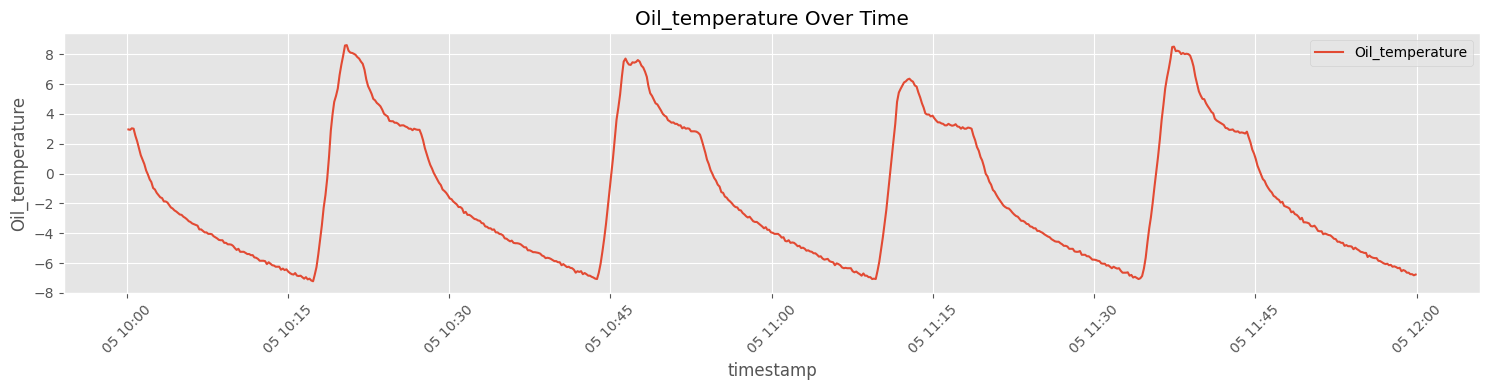

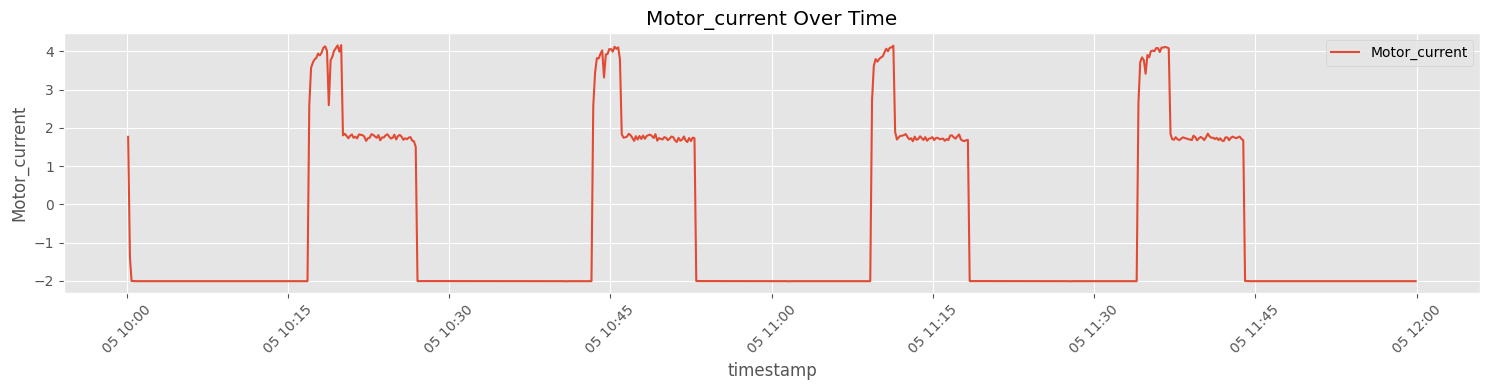

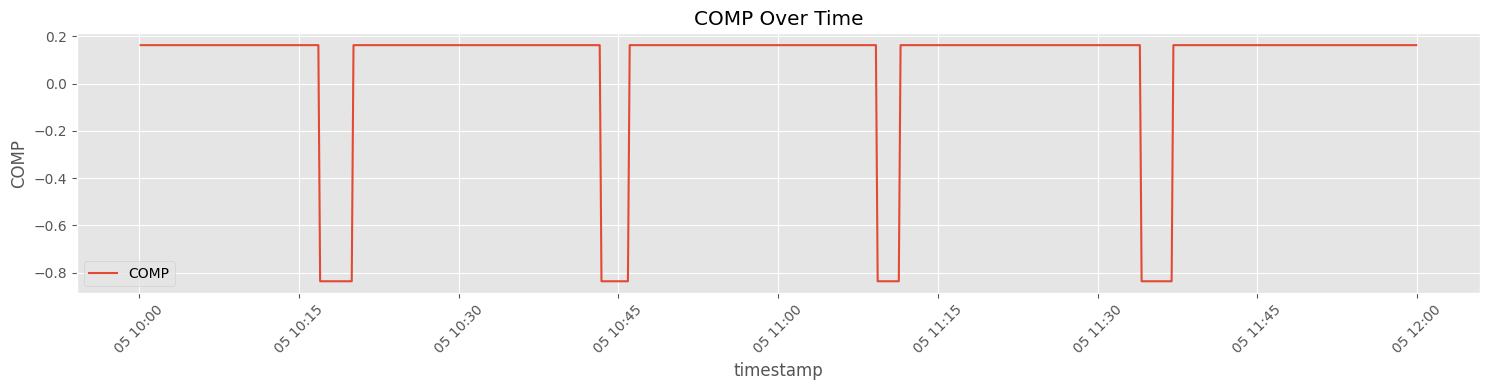

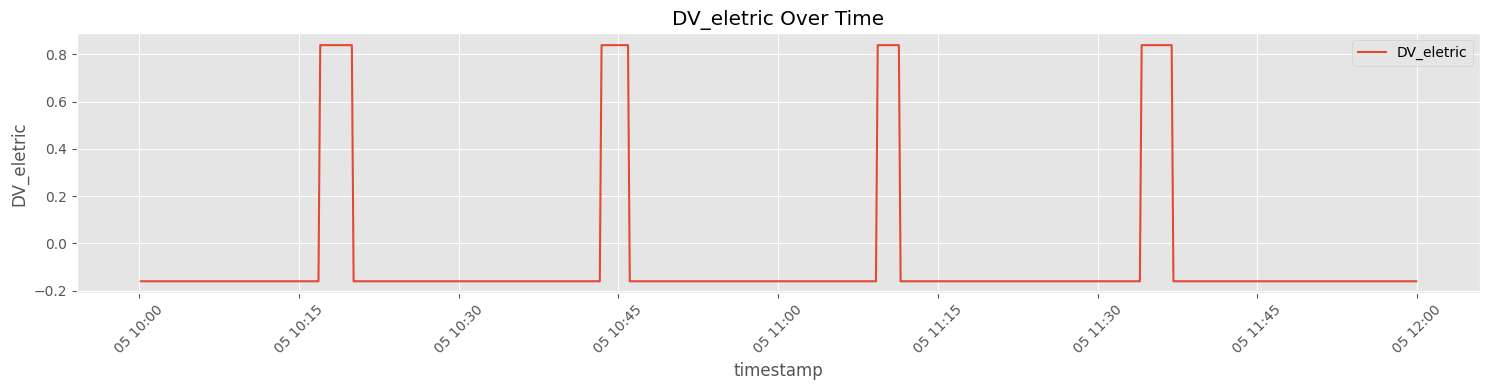

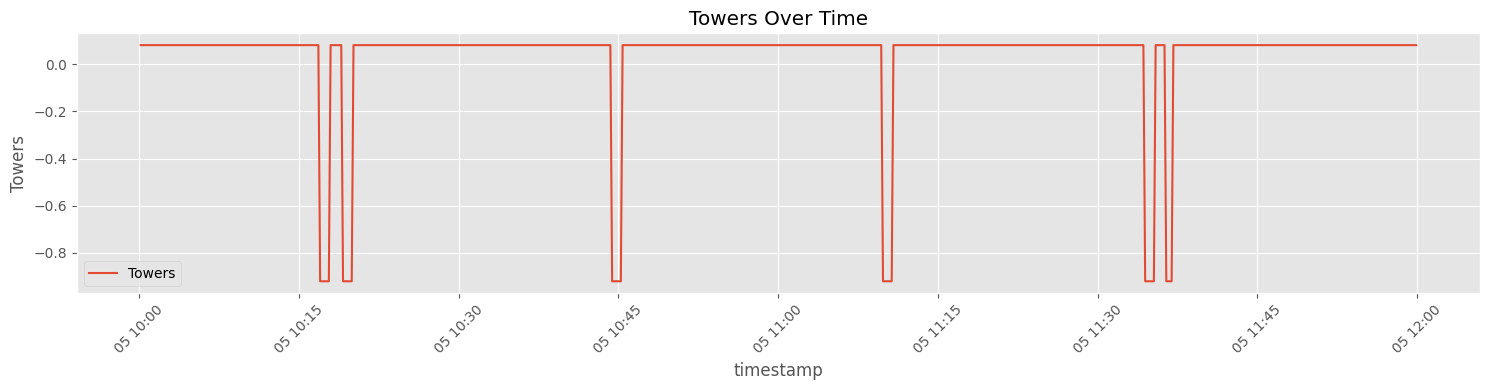

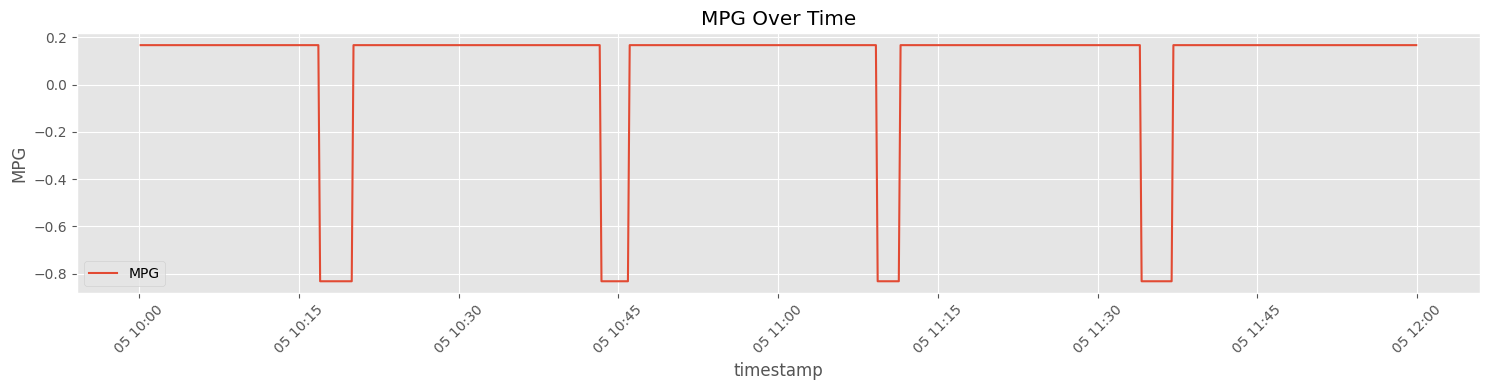

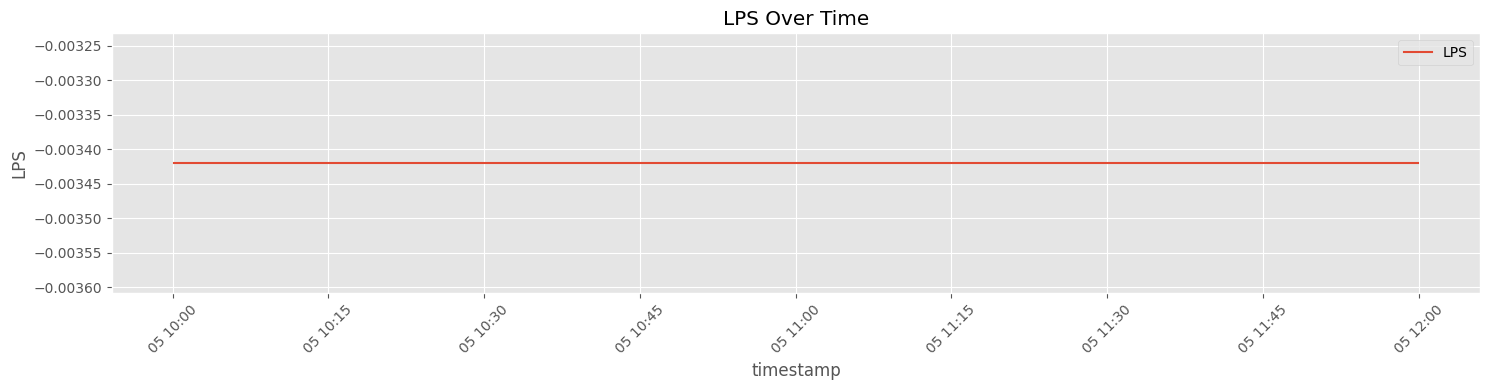

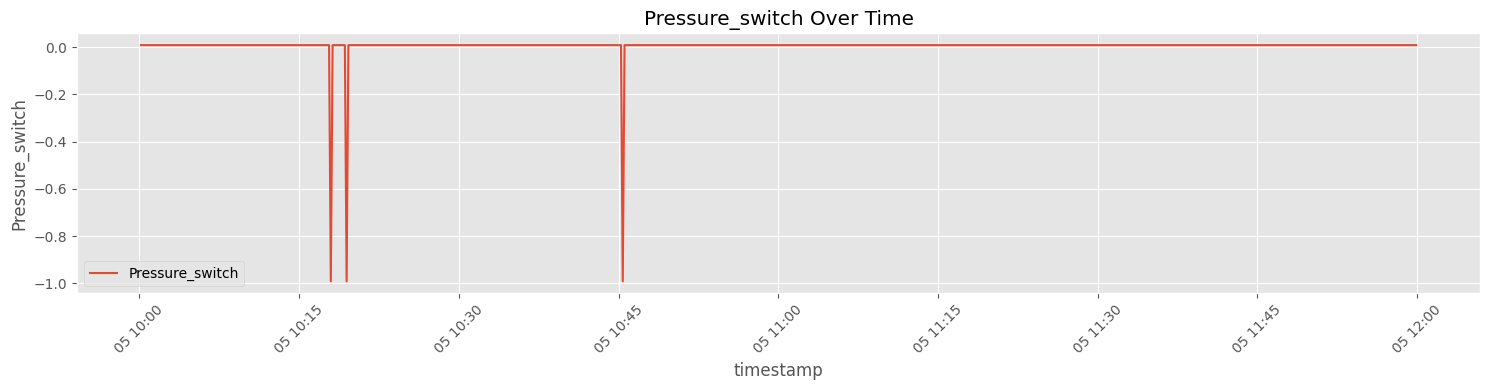

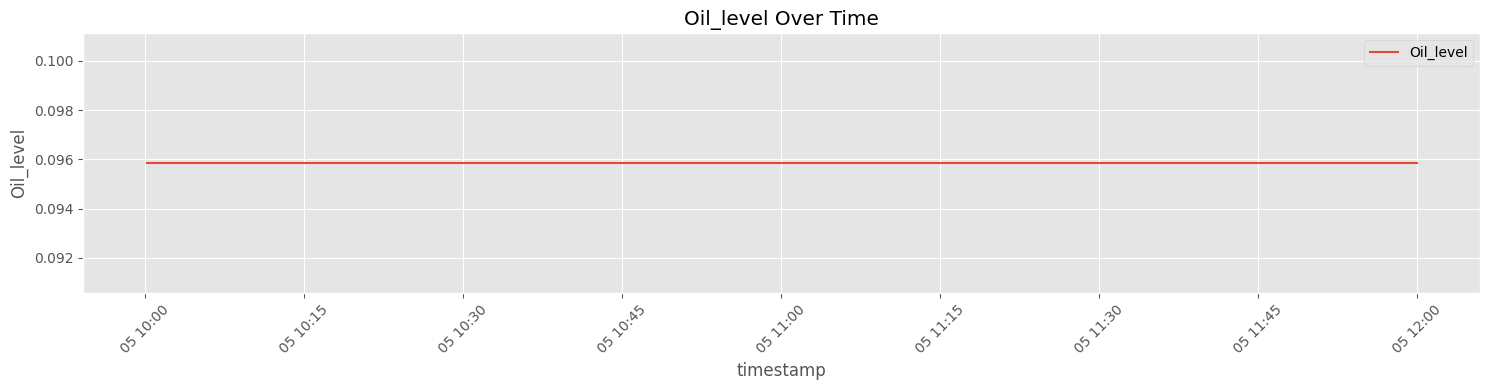

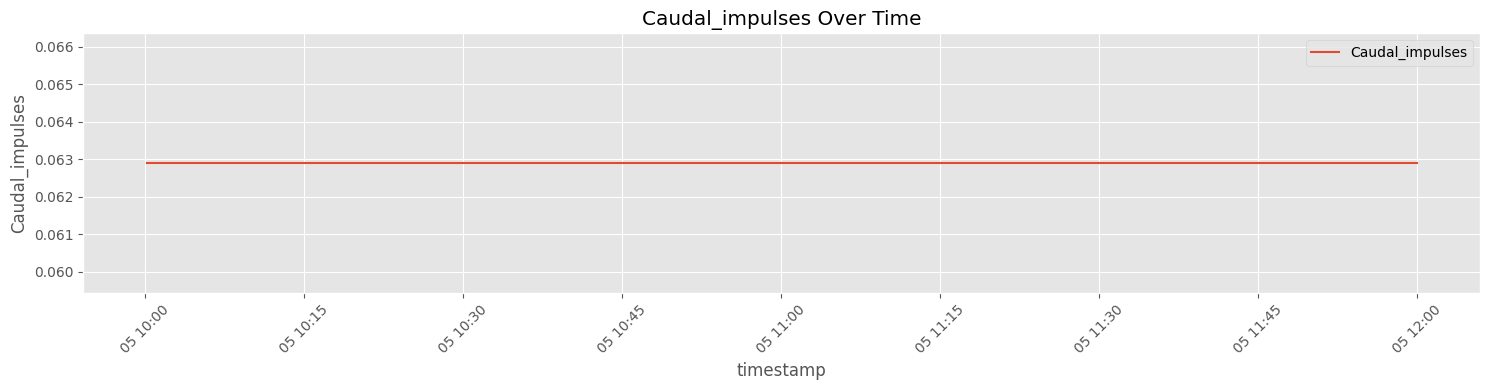

In [27]:
start_date = pl.datetime(2020, 4, 5, 10)
end_date = pl.datetime(2020, 4, 5, 12)
for col in data_norm.select(pl.exclude("timestamp")).columns:
    plot_time_series(data_norm, col, start_date, end_date)

In [28]:
def plot_all_time_series(
    data: pl.DataFrame,
    start_date: datetime.datetime,
    end_date: datetime.datetime,
):
    # Filter the data
    filtered_data = data.filter(
        (pl.col("timestamp") >= start_date) & (pl.col("timestamp") <= end_date)
    )

    plt.figure(figsize=(15, 6))
    for col in data.select(pl.exclude("timestamp")).columns:
        sns.lineplot(data=filtered_data, x="timestamp", y=col, label=col)
        plt.title("All Variables Over Time")
        plt.xticks(rotation=45)
        plt.tight_layout()
    plt.show()

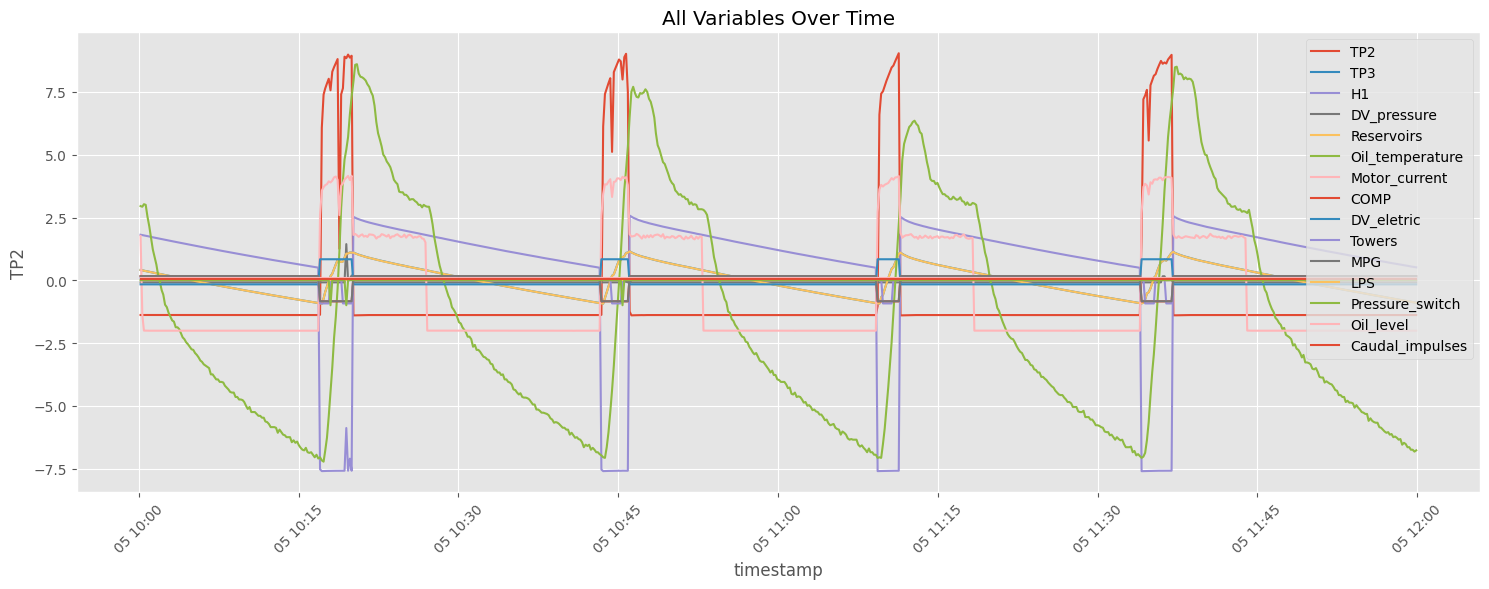

In [29]:
plot_all_time_series(data_norm, start_date, end_date)

# Tests
- Aplicamos tests a las series temporales pare saber si son estacionarias. Si el valor crítico es mayor que el estadístico del test, podemos decir que no son estacionarias.

In [33]:
# Create time series for all columns except "timestamp"
time_series_dict = {}

for column in data_norm.columns:
    if column != "timestamp":
        ts = data_norm.select(["timestamp", column])
        ts = ts.set_sorted("timestamp")
        ts = ts.drop(pl.col("timestamp"))
        time_series_dict[column] = ts

In [34]:
"""
The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the test statistic is less than the critical value, we can say that time series is stationary.
"""
def check_adfuller(ts):
    # Dickey-Fuller test
    if ts.unique().height == 1:
        print("Constant time series")
    else:
        result = adfuller(ts, autolag="AIC")
        print("Test statistic: ", result[0])
        print("p-value: ", result[1])
        print("Critical Values:", result[4])

In [32]:
for column in data_norm.columns:
    if column != "timestamp":
        print(f"# ------ {column} ------ #")
        check_adfuller(time_series_dict[column][:10000])
        print("\n")

# ------ TP2 ------ #
Test statistic:  -19.02512742496025
p-value:  0.0
Critical Values: {'1%': np.float64(-3.4310060666449416), '5%': np.float64(-2.861829942334688), '10%': np.float64(-2.5669243311680274)}


# ------ TP3 ------ #
Test statistic:  -14.076428993243992
p-value:  2.879352210933757e-26
Critical Values: {'1%': np.float64(-3.431006330034765), '5%': np.float64(-2.861830058724424), '10%': np.float64(-2.566924393122448)}


# ------ H1 ------ #
Test statistic:  -18.13960396922178
p-value:  2.492966959988647e-30
Critical Values: {'1%': np.float64(-3.431006132472577), '5%': np.float64(-2.861829971423364), '10%': np.float64(-2.566924346651971)}


# ------ DV_pressure ------ #
Test statistic:  -99.712759153987
p-value:  0.0
Critical Values: {'1%': np.float64(-3.4310041633725734), '5%': np.float64(-2.861829101294412), '10%': np.float64(-2.566923883481157)}


# ------ Reservoirs ------ #
Test statistic:  -14.079807510545551
p-value:  2.841981165634075e-26
Critical Values: {'1%': np.fl